In [1]:
import os
import sys
import pypsa

import pypsa
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import logging
import warnings

from functools import reduce
from matplotlib.colors import ListedColormap
from pandas.api.types import CategoricalDtype

warnings.filterwarnings("ignore")
logger = logging.getLogger(__name__)
plt.style.use("ggplot")

In [ ]:
network_path = "elec_s_100_ec_lcopt_Co2L0.0-3H_3H-gtflex_2050_0.071_DF_0export.nc"
network_path_1 = "elec_s_100_ec_lcopt_Co2L0.2-3H_3H-gtflex_2050_0.071_DF_0export.nc"
network_path_2 = "elec_s_100_ec_lcopt_Co2L0.5-3H_3H-gtflex_2050_0.071_DF_0export.nc"

### Functions definitions

In [3]:
def explore_price_bus_carrier(network, carrier_name):
    carrier_in_focus = carrier_name

    buses_carrier_index = network.buses.index[network.buses.carrier == carrier_in_focus]
    fig, ax = plt.subplots()
    network.buses_t.marginal_price[buses_carrier_index].plot(legend=False, ax=ax)
    #ax.plot(x, y)
    #ax2.set_ylim(-100, 1000)     # set both limits
    ax.set_title(carrier_name)
    ax.set_ylabel("Marginal price [Euro/MWh]")

    print(carrier_name, ":", "%.2f" % network.buses_t.marginal_price[buses_carrier_index].mean().mean())

## Load networks

In [4]:
network_files_list = [
    network_path,
    network_path_1,
    network_path_2,
]

In [5]:
network_list = [None] * len(network_files_list)

In [6]:
for i, netw_path in enumerate(network_files_list):
   network_list[i] = pypsa.Network(netw_path) 

Index(['CO2 pipeline US0 0 <-> US0 47', 'CO2 pipeline US0 0 <-> US0 55',
       'CO2 pipeline US0 0 <-> US0 88', 'CO2 pipeline US0 0 <-> US0 89',
       'CO2 pipeline US0 0 <-> US0 96', 'CO2 pipeline US0 1 <-> US0 52',
       'CO2 pipeline US0 1 <-> US0 73', 'CO2 pipeline US0 1 <-> US0 77',
       'CO2 pipeline US0 10 <-> US0 43', 'CO2 pipeline US0 10 <-> US0 62',
       ...
       'CO2 pipeline US12 0 <-> US2 0', 'CO2 pipeline US13 0 <-> US7 0',
       'CO2 pipeline US14 0 <-> US16 0', 'CO2 pipeline US15 0 <-> US2 0',
       'CO2 pipeline US16 0 <-> US18 0', 'CO2 pipeline US19 0 <-> US21 0',
       'CO2 pipeline US19 0 <-> US9 0', 'CO2 pipeline US20 0 <-> US8 0',
       'CO2 pipeline US21 0 <-> US4 0', 'CO2 pipeline US3 0 <-> US6 0'],
      dtype='object', name='name', length=242)
Index(['CO2 pipeline US0 0 <-> US0 47', 'CO2 pipeline US0 0 <-> US0 55',
       'CO2 pipeline US0 0 <-> US0 88', 'CO2 pipeline US0 0 <-> US0 89',
       'CO2 pipeline US0 0 <-> US0 96', 'CO2 pipeline US0 1 <

## Check prices

(-10.0, 300.0)

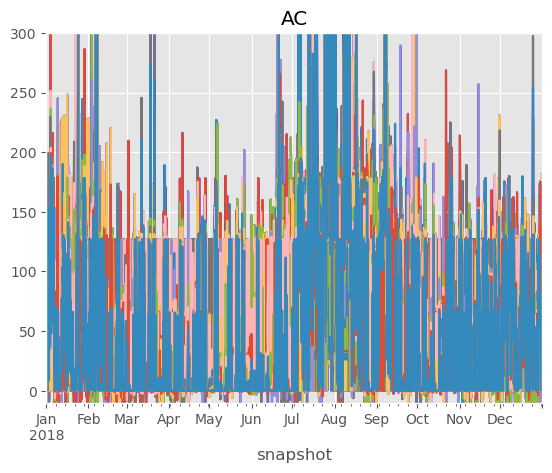

In [7]:
buses_ac_index = network_list[0].buses.index[network_list[0].buses.carrier == "AC"]

fig, ax = plt.subplots()
network_list[0].buses_t.marginal_price[buses_ac_index].plot(legend=False, ax=ax, color="blue")
network_list[0].buses_t.marginal_price[buses_ac_index].plot(legend=False, ax=ax)
ax.set_title("AC")
#ax.plot(x, y)
ax.set_ylim(-10, 300)

geothermal heat egs : 0.01
geothermal heat : 4.59
geothermal heat hs : 0.01
industry heat demand(50-80C) : 14.18
industry heat demand(80-150C) : 2.18
industry heat demand(150-250C) : 2.37
geothermal industry heat : 3.89
geothermal district heat : 80.89
H2 : -3613466.10
gas : 12.83
biogas : 65.75


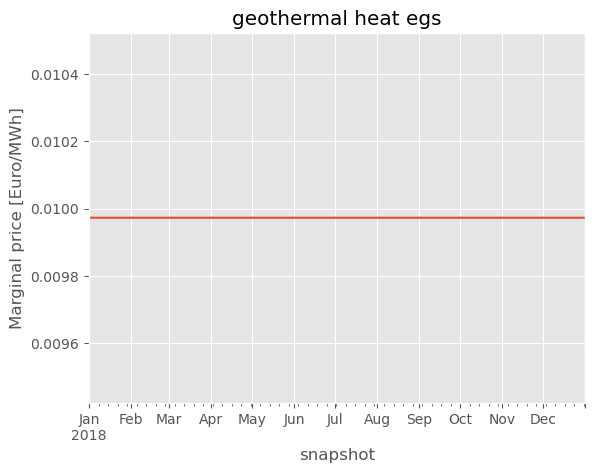

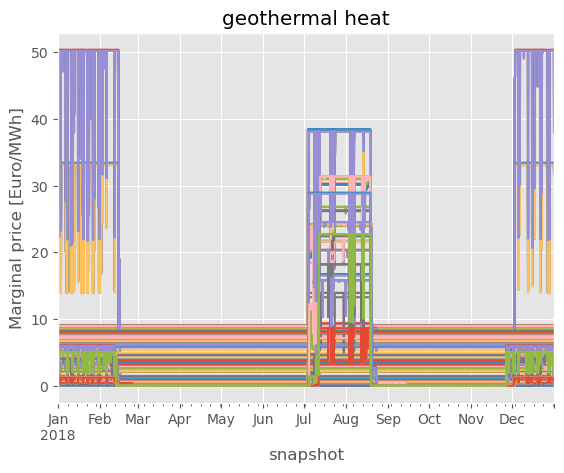

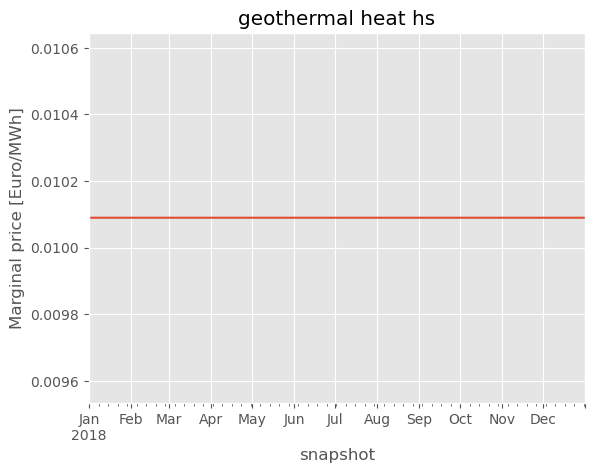

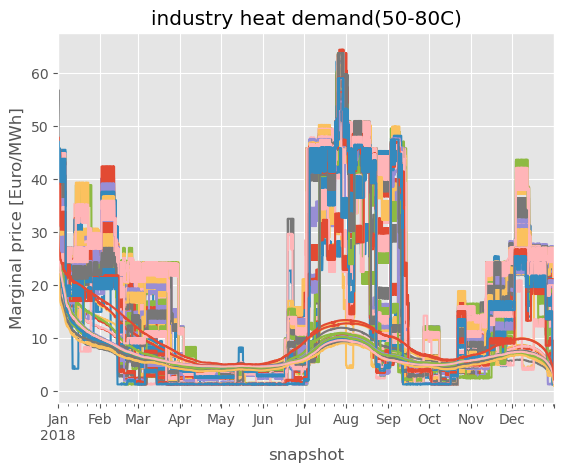

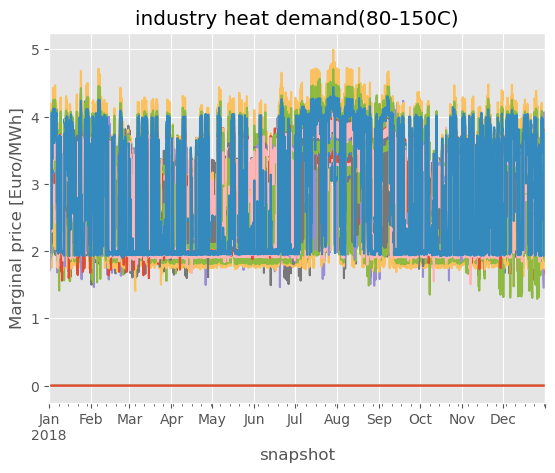

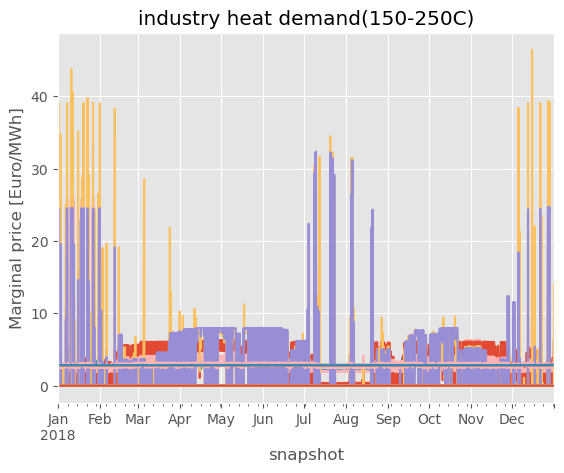

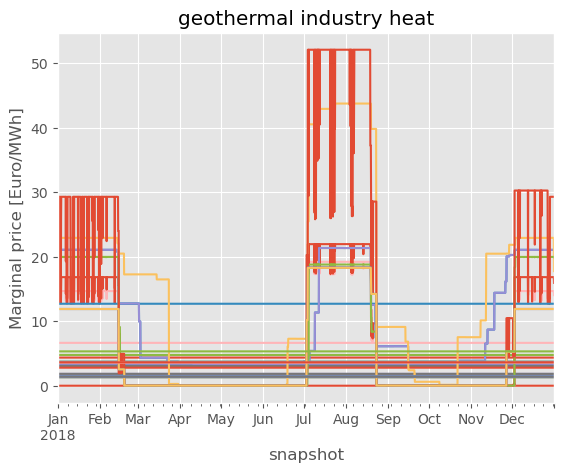

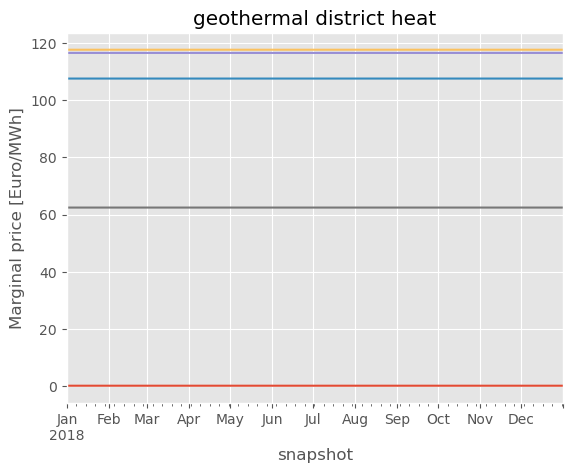

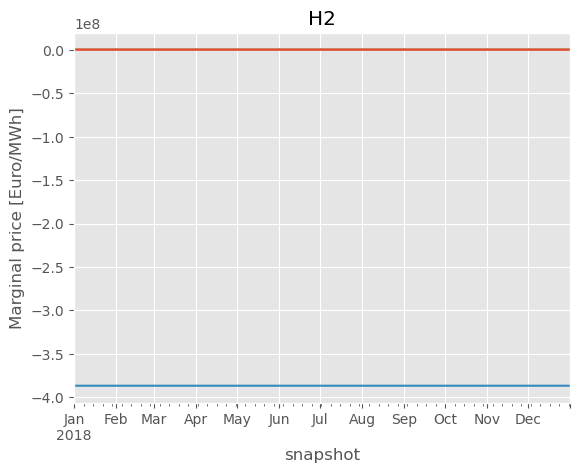

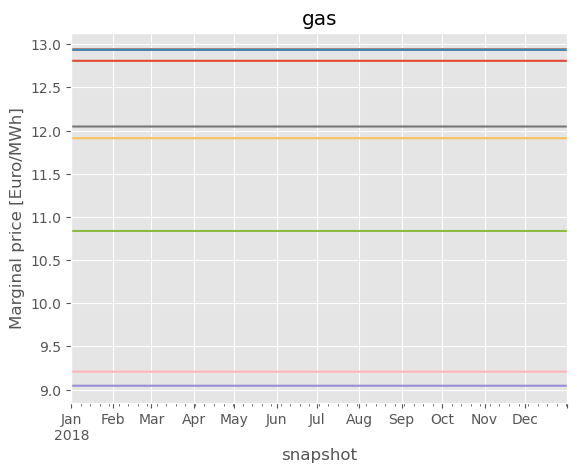

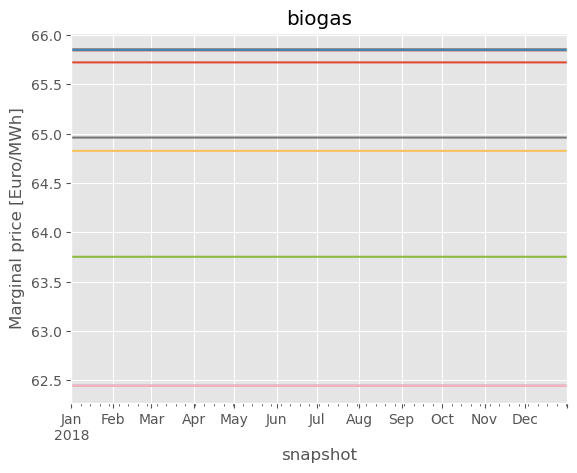

In [8]:
for carrier in [
        #'AC', 'DC', 
        'geothermal heat egs', 'geothermal heat',
        'geothermal heat hs', 'industry heat demand(50-80C)',
        'industry heat demand(80-150C)', 'industry heat demand(150-250C)',
        'geothermal industry heat', 'geothermal district heat',
        "H2", "gas", "biogas"
    ]:
    explore_price_bus_carrier(network_list[0], carrier)

### Check energy balances

In [9]:
carrier_in_focus = "AC"
buses_carrier_index = network_list[0].buses.index[network_list[0].buses.carrier == carrier_in_focus]
network_list[0].loads_t.p[buses_carrier_index].sum().sum() / 1e8

8.667289431489294

In [10]:
geothermal_buses_idx = network_list[0].buses.query("carrier == 'geothermal heat'").index
geothermal_available_sum = (
    network_list[0].links[network_list[0].links.bus1.isin(geothermal_buses_idx)].p_nom_max.sum()*
    (network_list[0].snapshot_weightings.generators) / 1e8
).sum()
print("%.2f" % geothermal_available_sum)

7.88


In [11]:
geothermal_used_sum = ( 
        network_list[0].statistics.energy_balance()[:, "geothermal power hs", :].values[0]+ 
        network_list[0].statistics.energy_balance()[:, "geothermal power egs", :].values[0]
    )/1e8
print("%.2f" % geothermal_used_sum)

2.85


In [12]:
geothermal_used_sum2 =( 
        (network_list[0].generators_t.p["geothermal power hs"]).mul((network_list[0].snapshot_weightings.generators)).sum()+
        (network_list[0].generators_t.p["geothermal power egs"]).mul((network_list[0].snapshot_weightings.generators)).sum()
    )/1e8
print("%.2f" % geothermal_used_sum2)

2.85


In [13]:
network_list[0].links[network_list[0].links.bus0.isin(geothermal_buses_idx)].head(2)

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
US0 1 geothermal power egs curve 1 producer,,NaN,NaN,NaN,US0 1 geothermal power egs curve 1 reservoir,US0 1,0.0,NaN,NaN,NaN,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
US0 1 geothermal power egs curve 2 producer,,NaN,NaN,NaN,US0 1 geothermal power egs curve 2 reservoir,US0 1,0.0,NaN,NaN,NaN,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [14]:
network_list[0].links[network_list[0].links.bus1.isin(geothermal_buses_idx)].head(2)

,tag_type,v_nom,num_parallel,tag_frequency,bus0,bus1,length,underground,under_construction,dc,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
US0 1 geothermal power egs curve 1 injector,,NaN,NaN,NaN,geothermal power egs,US0 1 geothermal power egs curve 1 reservoir,0.0,NaN,NaN,NaN,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
US0 1 geothermal power egs curve 2 injector,,NaN,NaN,NaN,geothermal power egs,US0 1 geothermal power egs curve 2 reservoir,0.0,NaN,NaN,NaN,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
